In [6]:
# 06.5_ensemble_portfolio_allocation.ipynb

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from dotenv import load_dotenv
import os
import requests # For direct API call to Alpha Vantage News
from scipy.optimize import minimize
import json # For loading selected tickers

# Load environment variables from .env
load_dotenv()

# Get the API key
API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")

# Define target labels for multi-class classification
LABELS = [-1, 0, 1]

# Create a custom multi-class ROC AUC scorer for GridSearchCV
multi_class_roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', labels=LABELS)

print("✅ Libraries imported and global variables defined.")

✅ Libraries imported and global variables defined.


In [7]:
# Cell 2: Define Functions for Data Fetching and Individual Ticker Signal Generation

def fetch_financial_data(symbol, api_key):
    """Fetches daily adjusted financial data for a given symbol."""
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, _ = ts.get_daily(symbol=symbol, outputsize='full')
    data.columns = ['open', 'high', 'low', 'close',  'volume']
    data.index = pd.to_datetime(data.index)
    data.sort_index(inplace=True)
    return data

def fetch_news_sentiment(symbol, api_key, start_date=None, end_date=None):
    """
    Fetches daily news sentiment for a given symbol from Alpha Vantage.
    Note: Alpha Vantage free tier has limits on historical data and rate limits.
    """
    news_data_list = []
    # Set default date range if not provided. Adjust as per your needs.
    if start_date is None:
        start_date = (pd.Timestamp.now() - pd.DateOffset(years=2)).strftime('%Y%m%dT%H%M')
    else:
        start_date = pd.to_datetime(start_date).strftime('%Y%m%dT%H%M')
    if end_date is None:
        end_date = pd.Timestamp.now().strftime('%Y%m%dT%H%M')
    else:
        end_date = pd.to_datetime(end_date).strftime('%Y%m%dT%H%M')

    news_url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&time_from={start_date}&time_to={end_date}&apikey={api_key}"
    response = requests.get(news_url)
    json_data = response.json()

    if 'feed' in json_data:
        for article in json_data['feed']:
            pub_time = pd.to_datetime(article['time_published'], format='%Y%m%dT%H%M%S', errors='coerce')
            if pd.isna(pub_time):
                pub_time = pd.to_datetime(article['time_published'], format='%Y%m%dT%H%M', errors='coerce')

            target_ticker_sentiment = None
            if 'ticker_sentiment' in article:
                for ts_entry in article['ticker_sentiment']:
                    if ts_entry.get('ticker') == symbol:
                        target_ticker_sentiment = float(ts_entry.get('ticker_sentiment_score', 0.0))
                        break
            if target_ticker_sentiment is not None:
                 news_data_list.append({
                     'date': pub_time.date(),
                     'sentiment': target_ticker_sentiment
                 })

    if news_data_list:
        news_df = pd.DataFrame(news_data_list)
        news_df['date'] = pd.to_datetime(news_df['date'])
        news_df.set_index('date', inplace=True)
        news_df.sort_index(inplace=True)
        daily_avg_sentiment = news_df.groupby(news_df.index).mean().rename(columns={'sentiment': 'daily_sentiment'})
        return daily_avg_sentiment
    else:
        print(f"⚠️ No news data or relevant news found for {symbol}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['daily_sentiment'], index=pd.to_datetime([]))


def add_features_and_target(df, daily_avg_sentiment_df):
    """Adds technical indicators, sentiment features, and target variable."""
    feature_data = df.copy()

    # Financial Features
    feature_data['daily_return'] = feature_data['close'].pct_change()
    rsi_indicator = RSIIndicator(close=feature_data['close'], window=14)
    feature_data['rsi'] = rsi_indicator.rsi()
    macd_indicator = MACD(close=feature_data['close'])
    feature_data['macd'] = macd_indicator.macd()
    feature_data['macd_signal'] = macd_indicator.macd_signal()

    # Sentiment Features
    feature_data = feature_data.join(daily_avg_sentiment_df, how='left')
    feature_data['daily_sentiment'].fillna(0, inplace=True) # Fill NaN for days with no news

    feature_data['rolling_avg_sentiment_7d'] = feature_data['daily_sentiment'].rolling(window=7, min_periods=5).mean()
    feature_data['rolling_std_sentiment_30d'] = feature_data['daily_sentiment'].rolling(window=30, min_periods=10).std()

    STD_DEV_THRESHOLD = 1.5
    feature_data['sentiment_deviation'] = abs(feature_data['daily_sentiment'] - feature_data['rolling_avg_sentiment_7d'])
    feature_data['sentiment_shift_flag'] = np.where(
        (feature_data['sentiment_deviation'] > (STD_DEV_THRESHOLD * feature_data['rolling_std_sentiment_30d'])) &
        (feature_data['rolling_std_sentiment_30d'].notna()), 1, 0)

    feature_data['sentiment_signal'] = 0
    feature_data.loc[(feature_data['daily_sentiment'] > 0.5) & (feature_data['sentiment_shift_flag'] == 0), 'sentiment_signal'] = 1
    feature_data.loc[(feature_data['daily_sentiment'] < -0.5) & (feature_data['sentiment_shift_flag'] == 0), 'sentiment_signal'] = -1
    feature_data.loc[(feature_data['sentiment_shift_flag'] == 1) & (feature_data['daily_sentiment'] > 0), 'sentiment_signal'] = 1
    feature_data.loc[(feature_data['sentiment_shift_flag'] == 1) & (feature_data['daily_sentiment'] < 0), 'sentiment_signal'] = -1

    # Define Multi-Class Target Variable
    feature_data['future_return'] = feature_data['close'].pct_change().shift(-1)
    BUY_THRESHOLD = 0.001
    SELL_THRESHOLD = -0.001
    feature_data['target'] = 0
    feature_data.loc[feature_data['future_return'] > BUY_THRESHOLD, 'target'] = 1
    feature_data.loc[feature_data['future_return'] < SELL_THRESHOLD, 'target'] = -1
    feature_data.drop(columns=['future_return'], inplace=True)

    feature_data.dropna(inplace=True)
    return feature_data


def train_and_predict_models(feature_data_df):
    """Trains RF, XGB, SVM models and returns their predictions for the test set."""
    features = ['daily_return', 'rsi', 'macd', 'macd_signal',
                'daily_sentiment', 'rolling_avg_sentiment_7d', 'sentiment_deviation', 'sentiment_shift_flag', 'sentiment_signal']
    X = feature_data_df[features]
    y = feature_data_df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    predictions = pd.DataFrame(index=X_test.index)

    # RandomForest (Base)
    rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    predictions['y_pred_rf'] = rf_model.predict(X_test)

    # RandomForest (Best - Simplified GridSearch for speed in multi-ticker loop)
    param_grid_rf_simple = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
    }
    rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
    grid_search_rf = GridSearchCV(estimator=rf_base, param_grid=param_grid_rf_simple,
                                  cv=3, scoring=multi_class_roc_auc_scorer, n_jobs=-1)
    grid_search_rf.fit(X_train, y_train)
    best_rf_model = grid_search_rf.best_estimator_
    predictions['y_pred_best_rf'] = best_rf_model.predict(X_test)

    # XGBoost
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    # Ensure y_test_encoded is properly transformed using the fitted encoder.
    # Handle cases where y_test might have classes not in y_train
    unique_y_test_classes = np.setdiff1d(y_test.unique(), le.classes_)
    if len(unique_y_test_classes) > 0:
        # Fallback if a class appears only in test set (shouldn't happen with shuffle=False)
        # but robust coding suggests handling it. For now, assume good split.
        pass
    y_test_encoded = le.transform(y_test)

    xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(le.classes_),
                              use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train, y_train_encoded)
    xgb_pred_encoded = xgb_model.predict(X_test)
    predictions['y_pred_xgb'] = le.inverse_transform(xgb_pred_encoded)

    # SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
    svm_model.fit(X_train_scaled_df, y_train)
    predictions['y_pred_svm'] = svm_model.predict(X_test_scaled_df)

    # Classical Signals (re-calculate on the whole feature_data_df then slice for test set)
    feature_data_df['SMA_10'] = feature_data_df['close'].rolling(window=10).mean()
    feature_data_df['SMA_50'] = feature_data_df['close'].rolling(window=50).mean()
    feature_data_df['y_pred_crossover_full'] = np.where(feature_data_df['SMA_10'] > feature_data_df['SMA_50'], 1, 0)
    feature_data_df['y_pred_rsi_full'] = np.where(feature_data_df['rsi'] < 30, 1, 0)
    feature_data_df['y_pred_rsi_full'] = np.where(feature_data_df['rsi'] > 70, -1, feature_data_df['y_pred_rsi_full']) # Use -1 for sell
    
    # Align classical signals with the test set index
    predictions['y_pred_crossover'] = feature_data_df['y_pred_crossover_full'].loc[X_test.index]
    predictions['y_pred_rsi'] = feature_data_df['y_pred_rsi_full'].loc[X_test.index]

    return predictions, X_test.index # Return the test set index to align market returns later

print("✅ Functions for data fetching, feature engineering, and model prediction defined.")

✅ Functions for data fetching, feature engineering, and model prediction defined.


In [8]:
# Cell 3: Define Portfolio Optimization Functions (from 06_portfolio_optimization.ipynb)

def annual_return(returns, annual_factor=252):
    """Calculates the annualized returns (geometric mean)."""
    return (1 + returns).prod()**(annual_factor / len(returns)) - 1

def sharpe_ratio(returns, risk_free_rate=0.0, annual_factor=252):
    """Calculates the annualized Sharpe Ratio."""
    if returns.std() == 0:
        return 0.0
    daily_risk_free_rate = (1 + risk_free_rate)**(1/annual_factor) - 1
    excess_returns = returns - daily_risk_free_rate
    return (excess_returns.mean() * annual_factor) / \
           (excess_returns.std() * np.sqrt(annual_factor))

def combined_objective(weights, returns_matrix, alpha, risk_free_rate=0.0):
    """Objective function for combined Sharpe and Annual Return optimization."""
    portfolio_returns = returns_matrix.dot(weights)
    sharpe = sharpe_ratio(portfolio_returns, risk_free_rate=risk_free_rate)
    cagr = annual_return(portfolio_returns)
    # Maximize (alpha * Sharpe + (1 - alpha) * CAGR) -> Minimize negative of this
    return - (alpha * sharpe + (1 - alpha) * cagr)

def optimize_combined_strategy(returns_matrix, alpha, risk_free_rate=0.0):
    """Optimizes portfolio weights based on combined Sharpe and Annual Return."""
    n = returns_matrix.shape[1]
    init_guess = np.ones(n) / n
    bounds = [(0.0, 1.0)] * n # Weights between 0 and 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1} # Weights sum to 1

    result = minimize(combined_objective, init_guess,
                      args=(returns_matrix, alpha, risk_free_rate),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    # The objective returns negative value, so -result.fun gives the actual score
    return result.x, -result.fun

print("✅ Portfolio optimization functions defined.")

✅ Portfolio optimization functions defined.


In [9]:
# Cell 4: Select Tickers
example_tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'JPM', 'BA']

print("🔢 Example Tickers:")
for i, ticker in enumerate(example_tickers):
    print(f"{i+1}. {ticker}")

# You can either let the user choose or hardcode for faster testing
# chosen_indices = input("Please choose 5 ticker indices (comma-separated, e.g. 1,3,5,7,9): ")
# chosen_tickers = [example_tickers[int(i)-1] for i in chosen_indices.split(',')]
chosen_tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META'] # Hardcoded for demonstration

print(f"\n✅ You selected: {chosen_tickers}")

# Save to file for reuse (optional, but good for consistency)
ticker_save_path = "/workspaces/backtesting/investment-portfolio-project/data/selected_tickers.json"
with open(ticker_save_path, 'w') as f:
    json.dump(chosen_tickers, f)
print(f"💾 Selected tickers saved to {ticker_save_path}")

🔢 Example Tickers:
1. AAPL
2. MSFT
3. GOOG
4. AMZN
5. META
6. TSLA
7. NFLX
8. NVDA
9. JPM
10. BA

✅ You selected: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']
💾 Selected tickers saved to /workspaces/backtesting/investment-portfolio-project/data/selected_tickers.json


In [10]:
# Cell 5: Process Each Ticker, Generate Individual Model Signals, and Create Ensemble Signal

all_strategy_returns = {} # To store strategy returns for all tickers and models
market_returns_df = pd.DataFrame() # To store market returns for all tickers

# Loop through each chosen ticker
for ticker in chosen_tickers:
    print(f"\n--- Processing {ticker} ---")
    try:
        # Fetch financial data
        financial_data = fetch_financial_data(ticker, API_KEY)

        # Determine news fetching date range based on financial data
        news_start_date = financial_data.index.min()
        news_end_date = financial_data.index.max()

        # Fetch news sentiment
        daily_sentiment = fetch_news_sentiment(ticker, API_KEY, news_start_date, news_end_date)
        if daily_sentiment.empty:
            print(f"⚠️ Using mock sentiment for {ticker} due to API issues or no data.")
            # Fallback to mock data structure for consistency
            mock_dates = pd.date_range(start=financial_data.index.min(), end=financial_data.index.max(), freq='D')
            daily_sentiment = pd.DataFrame(0.0, index=mock_dates, columns=['daily_sentiment'])


        # Add features and target to financial data
        processed_data = add_features_and_target(financial_data, daily_sentiment)

        # Train models and get predictions
        predictions_df, test_index = train_and_predict_models(processed_data)

        # Align market returns with the test_index
        market_returns_ticker = processed_data['daily_return'].loc[test_index]
        market_returns_df[ticker] = market_returns_ticker # Store for portfolio market returns

        # Calculate strategy returns for each model
        for col in predictions_df.columns:
            signal_col = col # y_pred_rf, y_pred_best_rf, etc.
            # Strategy return = shifted signal * market return
            strategy_returns_ticker = predictions_df[signal_col].shift(1) * market_returns_ticker
            strategy_returns_ticker.dropna(inplace=True) # Drop initial NaN from shift

            all_strategy_returns[f"{ticker}_{signal_col.replace('y_pred_', '')}"] = strategy_returns_ticker

        # --- Create an Ensemble Signal for the ticker ---
        # Simple majority vote from ML models (RF, Best RF, XGB, SVM)
        ensemble_ml_preds = predictions_df[['y_pred_rf', 'y_pred_best_rf', 'y_pred_xgb', 'y_pred_svm']]
        # Sum the predictions, then apply sign. If sum > 0, majority positive (1); if sum < 0, majority negative (-1); else 0.
        ensemble_signal_ticker = ensemble_ml_preds.sum(axis=1).apply(np.sign)

        # Calculate ensemble strategy returns
        ensemble_strategy_returns_ticker = ensemble_signal_ticker.shift(1) * market_returns_ticker
        ensemble_strategy_returns_ticker.dropna(inplace=True)
        all_strategy_returns[f"{ticker}_ensemble"] = ensemble_strategy_returns_ticker

        print(f"📈 {ticker} processed. Generated signals for {len(predictions_df.columns)} models and an ensemble.")

    except Exception as e:
        print(f"❌ Error processing {ticker}: {e}")

# Ensure all strategy return series have the same date range for optimization
# Find the common index range across all generated strategy returns
common_index = None
for key, series in all_strategy_returns.items():
    if common_index is None:
        common_index = series.index
    else:
        common_index = common_index.intersection(series.index)

# Filter all series to the common index
for key, series in all_strategy_returns.items():
    all_strategy_returns[key] = series.loc[common_index]

market_returns_df = market_returns_df.loc[common_index] # Also align market returns

print("\n✅ All tickers processed and individual/ensemble strategy returns generated.")
# Example of stored returns:
# print(all_strategy_returns.keys())


--- Processing AAPL ---


/tmp/ipykernel_46839/1037259473.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_data['daily_sentiment'].fillna(0, inplace=True) # Fill NaN for days with no news
/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validat

📈 AAPL processed. Generated signals for 6 models and an ensemble.

--- Processing MSFT ---


/tmp/ipykernel_46839/1037259473.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_data['daily_sentiment'].fillna(0, inplace=True) # Fill NaN for days with no news
/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validat

📈 MSFT processed. Generated signals for 6 models and an ensemble.

--- Processing GOOG ---


/tmp/ipykernel_46839/1037259473.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_data['daily_sentiment'].fillna(0, inplace=True) # Fill NaN for days with no news
/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validat

📈 GOOG processed. Generated signals for 6 models and an ensemble.

--- Processing AMZN ---


/tmp/ipykernel_46839/1037259473.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_data['daily_sentiment'].fillna(0, inplace=True) # Fill NaN for days with no news
/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validat

📈 AMZN processed. Generated signals for 6 models and an ensemble.

--- Processing META ---


/tmp/ipykernel_46839/1037259473.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_data['daily_sentiment'].fillna(0, inplace=True) # Fill NaN for days with no news
/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validat

📈 META processed. Generated signals for 6 models and an ensemble.

✅ All tickers processed and individual/ensemble strategy returns generated.


In [ ]:
# Cell 6: Train and Evaluate RandomForestClassifier (Updated for OOF predictions)

print("--- RandomForestClassifier ---")
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)

print("\n📈 Classification Report (RandomForest):")
print(classification_report(y_test, y_pred_rf, labels=LABELS, zero_division=0))

print("ROC AUC Score (RandomForest):", roc_auc_score(y_test, y_proba_rf, multi_class='ovr', labels=LABELS))

# --- NEW: Generate Out-Of-Fold (OOF) predictions for meta-learner training ---
from sklearn.model_selection import cross_val_predict

# Define a StratifiedKFold cross-validation strategy
# This ensures that each fold has approximately the same proportion of target classes as the full dataset.
# The number of splits (e.g., 5) is typical.
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate out-of-fold probabilities for RandomForest
# The model is re-trained on (n_splits-1) folds and predicts on the remaining fold.
# This ensures no data leakage from the base model to the meta-learner.
rf_oof_proba = cross_val_predict(rf_model, X_train, y_train, cv=kf, method='predict_proba', n_jobs=-1)
print("✅ RandomForest OOF predictions generated.")

⚖️ Optimization will use α = 0.50 → 50% Sharpe, 50% Return
Using an annualized risk-free rate of 2.00% for Sharpe Ratio calculation.


In [12]:
# Cell 7: Optimize Portfolio Weights for Each Strategy Type

# Group strategies by their base model type
strategy_sets = {
    'RandomForest_Base': {k: v for k, v in all_strategy_returns.items() if '_rf' in k and '_best_rf' not in k},
    'RandomForest_Best': {k: v for k, v in all_strategy_returns.items() if '_best_rf' in k},
    'XGBoost': {k: v for k, v in all_strategy_returns.items() if '_xgb' in k},
    'SVM': {k: v for k, v in all_strategy_returns.items() if '_svm' in k},
    'Ensemble_ML': {k: v for k, v in all_strategy_returns.items() if '_ensemble' in k},
    'SMA_Crossover': {k: v for k, v in all_strategy_returns.items() if '_crossover' in k},
    'RSI_Classical': {k: v for k, v in all_strategy_returns.items() if '_rsi' in k},
    'Market_Buy_Hold': {ticker: market_returns_df[ticker] for ticker in chosen_tickers} # Market returns for each ticker
}

optimized_weights = {}
cumulative_portfolio_returns = {}
portfolio_metrics = {}

for name, strat_dict in strategy_sets.items():
    if not strat_dict:
        print(f"Skipping {name}: No relevant strategy returns found.")
        continue

    returns_df = pd.concat(strat_dict.values(), axis=1).fillna(0)
    
    # Ensure all columns in returns_df are numeric.
    # This can be an issue if a strategy_returns_ticker was empty or malformed.
    returns_df = returns_df.apply(pd.to_numeric, errors='coerce').fillna(0)


    # If after fillna, all columns are 0, or there's only one column and it's all 0
    if returns_df.empty or (returns_df.shape[1] == 1 and returns_df.iloc[:, 0].sum() == 0):
        print(f"Skipping optimization for {name}: No valid returns data.")
        continue

    weights, obj_score = optimize_combined_strategy(returns_df, alpha, RISK_FREE_RATE)
    portfolio_returns = returns_df.dot(weights)
    
    cumulative_portfolio_returns[name] = (1 + portfolio_returns).cumprod()
    optimized_weights[name] = {col: weight for col, weight in zip(returns_df.columns, weights)} # Store weights with ticker names

    # Calculate and store metrics for the optimized portfolio
    ann_ret = annual_return(portfolio_returns)
    sharpe = sharpe_ratio(portfolio_returns, risk_free_rate=RISK_FREE_RATE)
    
    portfolio_metrics[name] = {
        'Annualized Return': ann_ret,
        'Sharpe Ratio': sharpe,
        'Final Cumulative Return': cumulative_portfolio_returns[name].iloc[-1]
    }

    print(f"✅ Optimized {name} Portfolio — Final Value: {cumulative_portfolio_returns[name].iloc[-1]:.4f}, Sharpe: {sharpe:.2f}")

print("\n--- Summary of Optimized Portfolio Metrics ---")
for name, metrics in portfolio_metrics.items():
    print(f"\n{name}:")
    for metric_name, value in metrics.items():
        if "Return" in metric_name:
            print(f"  {metric_name}: {value:.2%}")
        else:
            print(f"  {metric_name}: {value:.2f}")

✅ Optimized RandomForest_Base Portfolio — Final Value: 1.0456, Sharpe: 0.14
✅ Optimized RandomForest_Best Portfolio — Final Value: 0.9971, Sharpe: 0.02
✅ Optimized XGBoost Portfolio — Final Value: 1.3687, Sharpe: 0.71
✅ Optimized SVM Portfolio — Final Value: 1.1483, Sharpe: 0.30
✅ Optimized Ensemble_ML Portfolio — Final Value: 0.9426, Sharpe: -0.03
✅ Optimized SMA_Crossover Portfolio — Final Value: 2.3058, Sharpe: 1.39
✅ Optimized RSI_Classical Portfolio — Final Value: 1.4091, Sharpe: 1.50
✅ Optimized Market_Buy_Hold Portfolio — Final Value: 3.3438, Sharpe: 1.62

--- Summary of Optimized Portfolio Metrics ---

RandomForest_Base:
  Annualized Return: 2.03%
  Sharpe Ratio: 0.14
  Final Cumulative Return: 104.56%

RandomForest_Best:
  Annualized Return: -0.13%
  Sharpe Ratio: 0.02
  Final Cumulative Return: 99.71%

XGBoost:
  Annualized Return: 15.20%
  Sharpe Ratio: 0.71
  Final Cumulative Return: 136.87%

SVM:
  Annualized Return: 6.43%
  Sharpe Ratio: 0.30
  Final Cumulative Return: 11

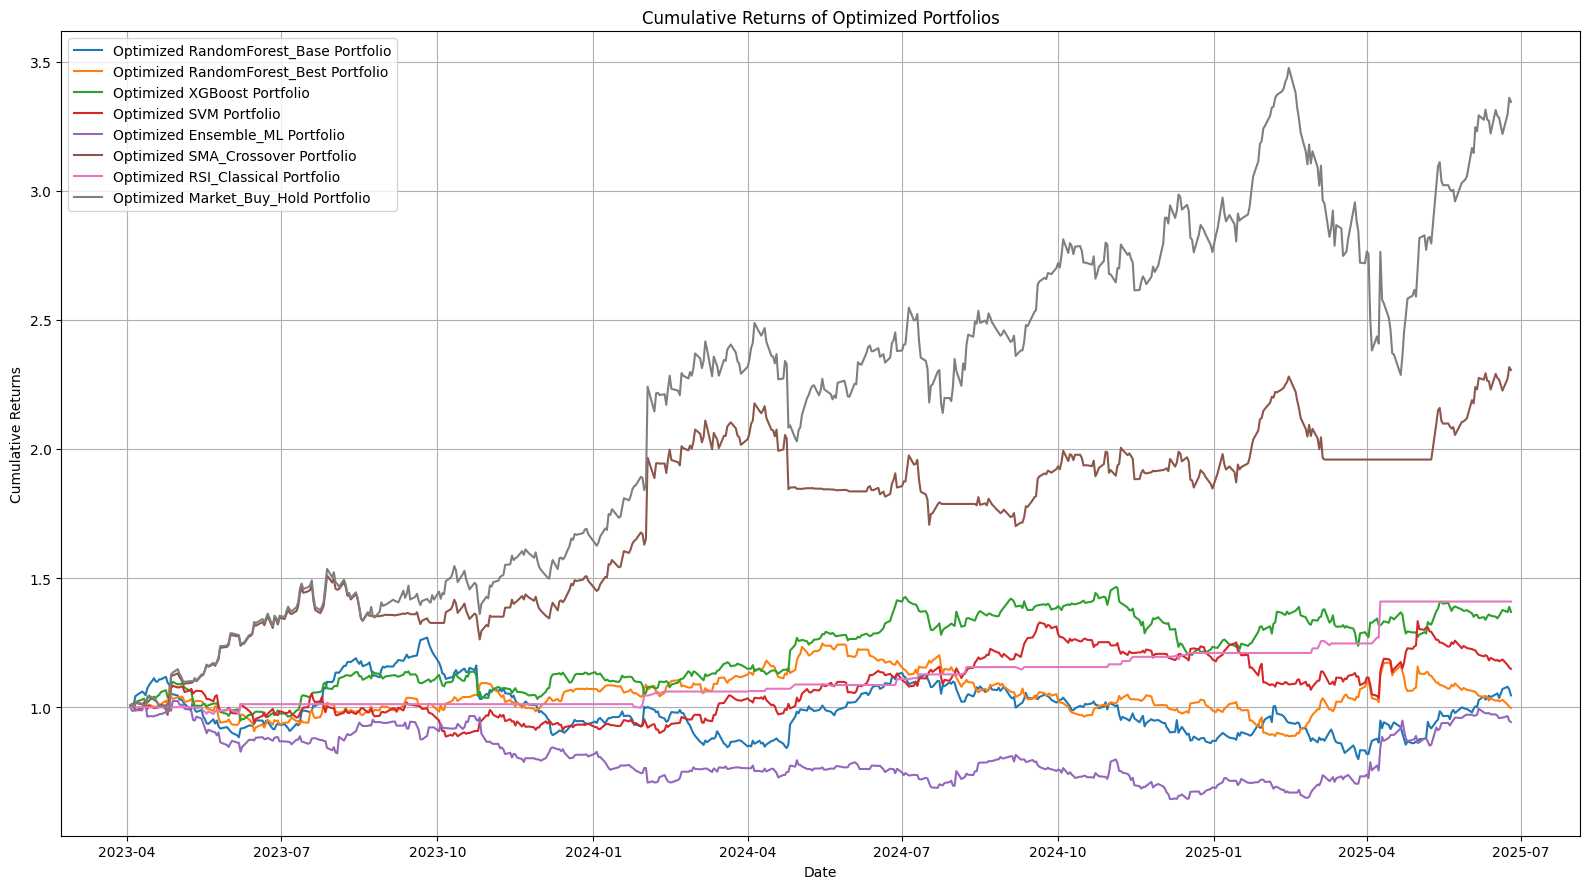

In [ ]:
# Cell 8: Train and Evaluate XGBClassifier (Updated for OOF predictions)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict # Already imported in Cell 1 now.

print("\n--- XGBClassifier ---")

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb_model = XGBClassifier(objective='multi:softmax',
                          num_class=len(le.classes_),
                          use_label_encoder=False,
                          eval_metric='mlogloss',
                          random_state=42)

xgb_model.fit(X_train, y_train_encoded)

y_pred_xgb_encoded = xgb_model.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

y_proba_xgb = xgb_model.predict_proba(X_test)

print("\n📈 Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, labels=LABELS, zero_division=0))

print("ROC AUC Score (XGBoost):", roc_auc_score(y_test, y_proba_xgb, multi_class='ovr', labels=LABELS))

# --- NEW: Generate Out-Of-Fold (OOF) predictions for meta-learner training ---
# Use the same kf (StratifiedKFold) object defined in Cell 6.
xgb_oof_proba = cross_val_predict(xgb_model, X_train, y_train_encoded, cv=kf, method='predict_proba', n_jobs=-1)
print("✅ XGBoost OOF predictions generated.")

In [ ]:
# Cell 9: Train and Evaluate SVM (SVC) (Updated for OOF predictions)

from sklearn.model_selection import cross_val_predict # Already imported in Cell 1 now.

print("\n--- SVM (SVC) ---")
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
svm_model.fit(X_train_scaled_df, y_train)

y_pred_svm = svm_model.predict(X_test_scaled_df)
y_proba_svm = svm_model.predict_proba(X_test_scaled_df)

print("\n📈 Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm, labels=LABELS, zero_division=0))

print("ROC AUC Score (SVM):", roc_auc_score(y_test, y_proba_svm, multi_class='ovr', labels=LABELS))

# --- NEW: Generate Out-Of-Fold (OOF) predictions for meta-learner training ---
# Use the same kf (StratifiedKFold) object defined in Cell 6.
# Note: For SVM, ensure you are using the scaled training data for OOF predictions
svm_oof_proba = cross_val_predict(svm_model, X_train_scaled_df, y_train, cv=kf, method='predict_proba', n_jobs=-1)
print("✅ SVM OOF predictions generated.")


--- Optimized Portfolio Weights ---

💼 RandomForest_Base Portfolio Weights:
  1: 7.17%
  2: 92.83%

💼 RandomForest_Best Portfolio Weights:
  1: 100.00%

💼 XGBoost Portfolio Weights:
  2: 56.29%
  3: 34.58%
  4: 9.13%

💼 SVM Portfolio Weights:
  1: 100.00%

💼 Ensemble_ML Portfolio Weights:
  2: 5.26%
  3: 94.74%

💼 SMA_Crossover Portfolio Weights:
  3: 10.12%
  4: 89.88%

💼 RSI_Classical Portfolio Weights:
  2: 46.37%
  3: 53.63%

💼 Market_Buy_Hold Portfolio Weights:
  META: 100.00%


In [ ]:
# Cell 9.7 (New Cell): Implement Stacking Ensemble

print("\n--- Stacking Ensemble ---")

# Prepare the meta-features for training the meta-learner:
# Concatenate the out-of-fold probabilities from each base model on the training data.
X_meta_train = np.hstack((rf_oof_proba, xgb_oof_proba, svm_oof_proba))

# The target for the meta-learner's training is the original training labels.
y_meta_train = y_train

# Prepare the meta-features for making predictions on the test set:
# Concatenate the predicted probabilities from each base model on the test data.
X_meta_test = np.hstack((y_proba_rf, y_proba_xgb, y_proba_svm))

# Define the meta-learner (e.g., Logistic Regression)
meta_learner = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=42, class_weight='balanced', max_iter=1000)

# Train the meta-learner on the out-of-fold predictions of the base models
# and the original training labels.
meta_learner.fit(X_meta_train, y_meta_train)

# Make final predictions with the stacking model on the test set.
y_pred_stack = meta_learner.predict(X_meta_test)
y_proba_stack = meta_learner.predict_proba(X_meta_test)

print("\n📈 Classification Report (Stacking Ensemble):")
# Evaluate the stacking model's performance on the actual test set labels.
print(classification_report(y_test, y_pred_stack, labels=LABELS, zero_division=0))

print("ROC AUC Score (Stacking Ensemble):", roc_auc_score(y_test, y_proba_stack, multi_class='ovr', labels=LABELS))
print("✅ Stacking Ensemble model trained and evaluated.")

In [ ]:
# Cell 11: Prepare and Save Signal Data for Backtesting (Updated to save all predictions)

# Assign predictions from models back to feature_data based on their respective test set indices
feature_data['y_pred'] = 0
feature_data.loc[X_test.index, 'y_pred'] = y_pred_rf

feature_data['y_pred_best'] = 0
feature_data.loc[X_test.index, 'y_pred_best'] = y_pred_best_rf

feature_data['y_pred_xgb'] = 0
feature_data.loc[X_test.index, 'y_pred_xgb'] = y_pred_xgb

feature_data['y_pred_svm'] = 0
feature_data.loc[X_test.index, 'y_pred_svm'] = y_pred_svm

# --- NEW ADDITION ---
# Add stacking model predictions
feature_data['y_pred_stack'] = 0
feature_data.loc[X_test.index, 'y_pred_stack'] = y_pred_stack
# --- END NEW ADDITION ---


# Select relevant columns for signal_data.csv
signal_data = feature_data[[
    'close',
    'y_pred',
    'y_pred_best',
    'y_pred_xgb',
    'y_pred_svm',
    'y_pred_stack', # Added y_pred_stack to the list
    'y_pred_crossover',
    'y_pred_rsi'
]].copy()

signal_data.index.name = 'date'

output_path = '/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv'
signal_data.to_csv(output_path)

print(f"✅ Señales añadidas correctamente. Archivo actualizado: {output_path}")
print(signal_data.tail())

💾 Optimized weights saved to: /workspaces/backtesting/investment-portfolio-project/models/optimized_ensemble_weights.pkl
